In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SequentialFeatureSelector

from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vT-0QS87d8OvzDJNeBR9dyYSCsHzGw6K3IM1qGP-GcMHlb_F4pK4uWyLH7dEs6yiitmKaFYH5pHqRc6/pub?output=csv')

In [ ]:
data.head()

,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,...,12.9,1.0,0.7,18.0,19.0,27.0,Y,0,Y,0
1,1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,...,12.7,1.0,0.6,22.0,19.0,18.0,Y,0,Y,0
2,2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,...,15.8,1.0,1.0,21.0,16.0,22.0,Y,0,N,1
3,3,M,40,165,70,88.0,1.5,1.5,1.0,1.0,...,14.7,1.0,1.0,19.0,26.0,18.0,Y,0,Y,0
4,4,F,40,155,60,86.0,1.0,1.0,1.0,1.0,...,12.5,1.0,0.6,16.0,14.0,22.0,Y,0,N,0


In [ ]:
print("Duplicated data points:", data.duplicated().sum())
print(data.columns)
data['oral'].value_counts()
print(data.shape)
data = data.dropna()
print(data.shape)  #no duplicated or missing points

Duplicated data points: 0
Index(['ID', 'gender', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)',
       'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)',
       'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol',
       'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein',
       'serum creatinine', 'AST', 'ALT', 'Gtp', 'oral', 'dental caries',
       'tartar', 'smoking'],
      dtype='object')
(55692, 27)
(55692, 27)


In [ ]:
data = data.drop('ID', axis = 1) #we already have it indexed, don't need the ID also
data = data.drop('eyesight(left)', axis = 1) # I don't know what this variable means
data = data.drop('eyesight(right)', axis = 1)
data = data.drop('Urine protein', axis = 1) #this doesn't make sense either
data = data.drop('oral', axis = 1) #all are true, can be removed
data = data.rename(columns = {'height(cm)' : "height"})
data = data.rename(columns = {'weight(kg)' : "weight"})
data = data.rename(columns = {'waist(cm)' : "waist"})
data = data.rename(columns = {'relaxation' : "diastolic"}) # pretty sure this is diastolic
data = data.rename(columns = {'fasting blood sugar' : "fbs"})
data = data.rename(columns = {'Cholesterol' : "cholesterol"})
data = data.rename(columns = {'Gtp' : "GGT"}) #pretty sure this is GGT
data = data.rename(columns = {'waist(cm)' : "waist"})
data = data.rename(columns = {'relaxation' : "diastolic"})
data = data.rename(columns = {'relaxation' : "diastolic"})
data['gender'] = data['gender'].replace({'F': 0, 'M': 1})
data['tartar'] = data['tartar'].replace({'Y': 0, 'N': 1})
data.head()

,gender,age,height,weight,waist,hearing(left),hearing(right),systolic,diastolic,fbs,...,HDL,LDL,hemoglobin,serum creatinine,AST,ALT,GGT,dental caries,tartar,smoking
0,0,40,155,60,81.3,1.0,1.0,114.0,73.0,94.0,...,73.0,126.0,12.9,0.7,18.0,19.0,27.0,0,0,0
1,0,40,160,60,81.0,1.0,1.0,119.0,70.0,130.0,...,42.0,127.0,12.7,0.6,22.0,19.0,18.0,0,0,0
2,1,55,170,60,80.0,1.0,1.0,138.0,86.0,89.0,...,55.0,151.0,15.8,1.0,21.0,16.0,22.0,0,1,1
3,1,40,165,70,88.0,1.0,1.0,100.0,60.0,96.0,...,45.0,226.0,14.7,1.0,19.0,26.0,18.0,0,0,0
4,0,40,155,60,86.0,1.0,1.0,120.0,74.0,80.0,...,62.0,107.0,12.5,0.6,16.0,14.0,22.0,0,1,0


In [ ]:
data['smoking'].value_counts()

0    35237
1    20455
Name: smoking, dtype: int64

In [ ]:
def eda(x):
    agg_data = data[data['smoking'] == 0].groupby(x).size().reset_index(name='nonsmoker')
    ag_data = data[data['smoking'] == 1].groupby(x).size().reset_index(name='smoker')
    fig, ax = plt.subplots()
    sns.lineplot(x=x, y='nonsmoker', data=agg_data, color = 'purple' , label = "Nonsmoker", ax = ax)
    sns.lineplot(x=x, y='smoker', data=ag_data, color = 'pink' , label = "Smoker", ax = ax )
    ax.set_xlabel(x)
    ax.set_ylabel("Number of subjects")
    ax.set_title('Smoking vs ' + x)

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()
def eda1(x, a, b):
    g_df = data.groupby(['smoking'])[x].value_counts(normalize=True).rename('smoke_count').reset_index()
    g_df.smoking.replace({1:"Smoker", 0:"Non-smoker"}, inplace=True)
    g_df[x].replace({1:a, 0:b}, inplace=True)
    g_df[x].replace({1:a, 2:b}, inplace=True)
    smoking_hd = sns.barplot(x='smoking', y='smoke_count', hue=x, data=g_df, palette=sns.color_palette("hls", 9))
    smoking_hd.set_title("Smoking vs "+ x,fontsize=20)
    smoking_hd.set_xlabel('Smoking',fontsize=12)
    smoking_hd.set_ylabel('Proportion of Subjects',fontsize=12)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    sns.set(rc={'figure.figsize':(8,6)})
    plt.show()

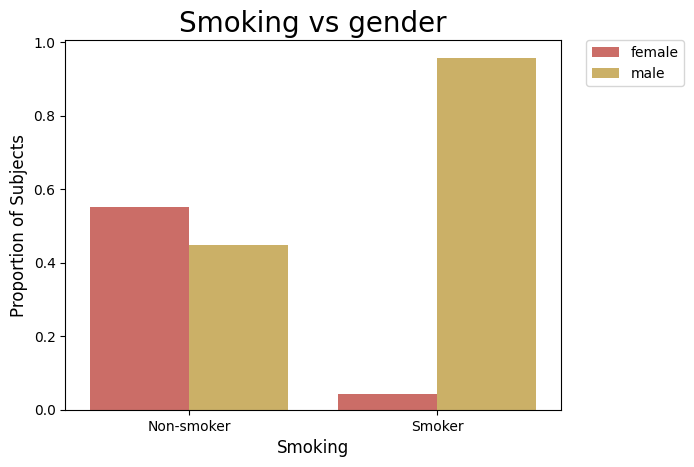

In [ ]:
eda1('gender', 'male', 'female') #important

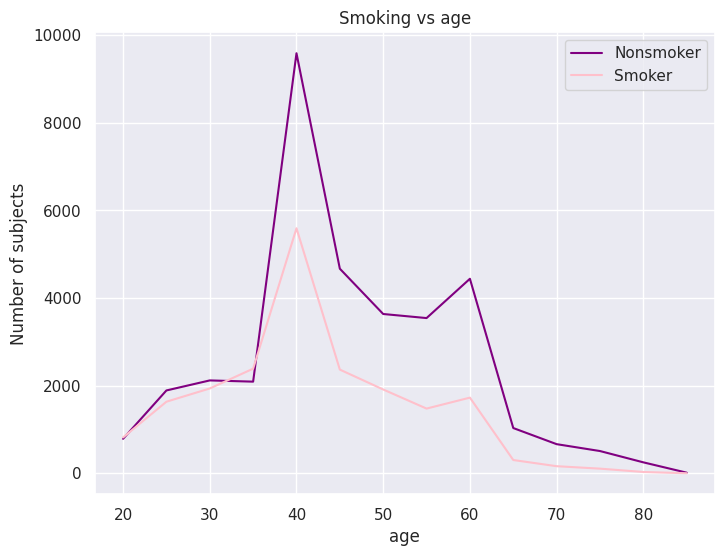

In [ ]:
eda('age') #not important

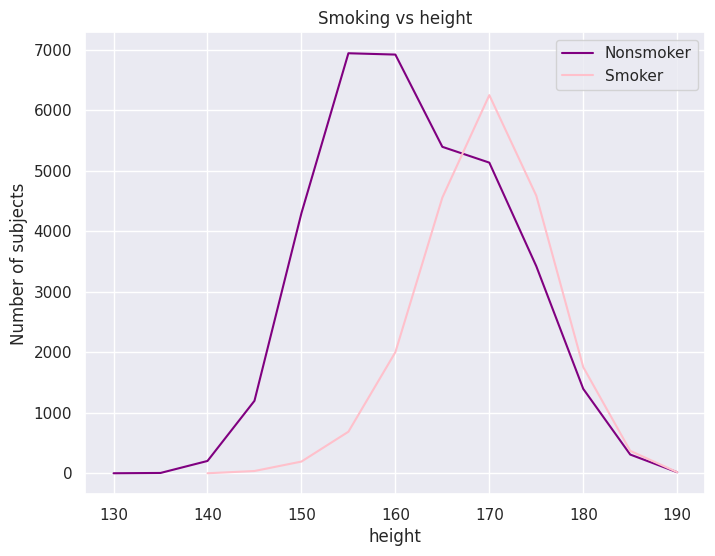

In [ ]:
eda('height') #important but probably just reflecting males

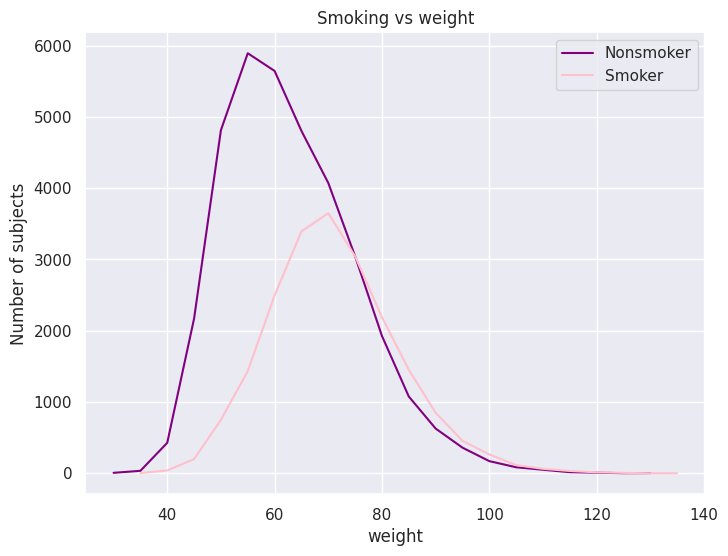

In [ ]:
eda('weight') #might be important though might be males

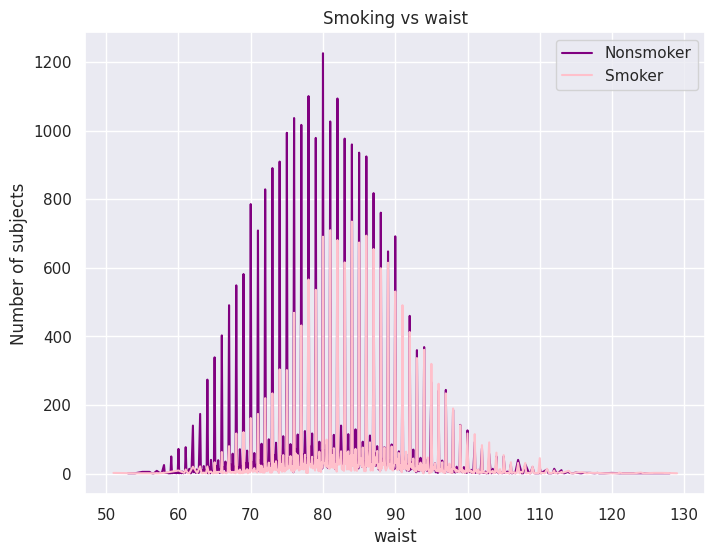

In [ ]:
eda('waist') #not important

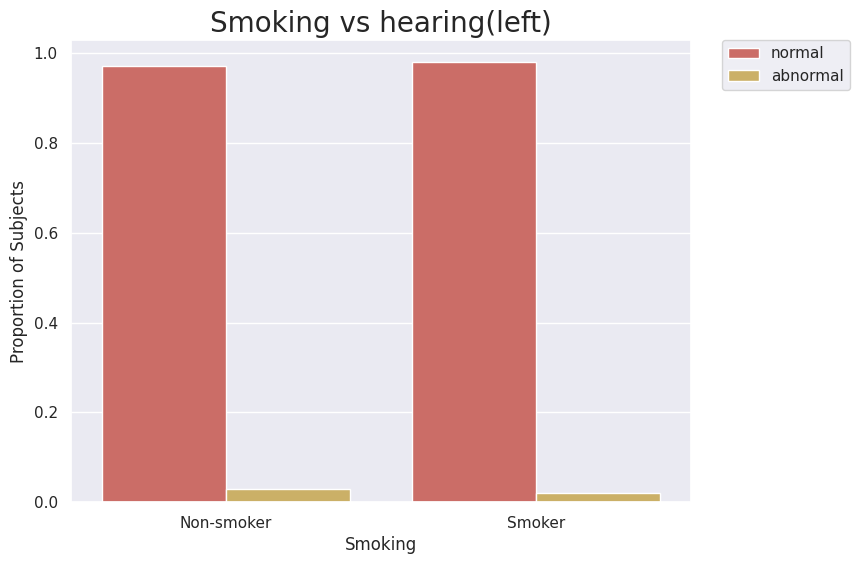

In [ ]:
eda1('hearing(left)', 'normal', 'abnormal') # not  important

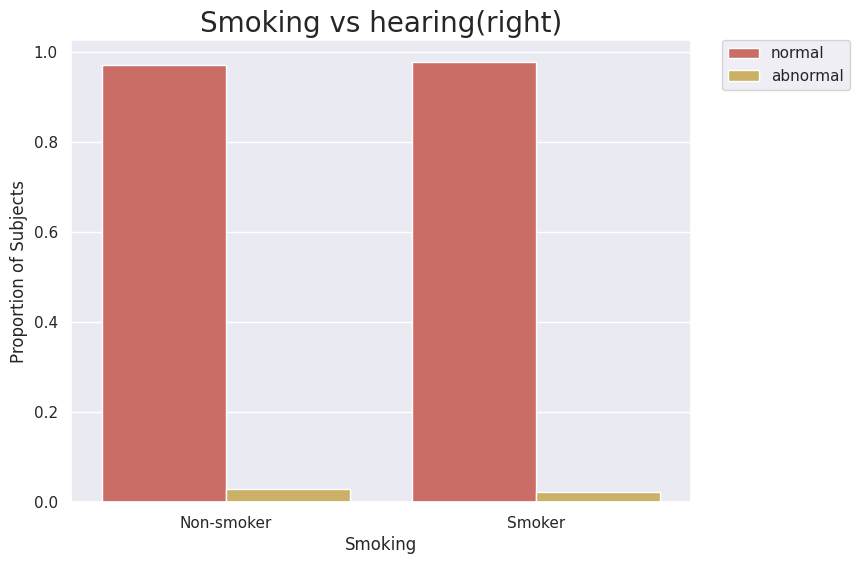

In [ ]:
eda1('hearing(right)', 'normal', 'abnormal') #not important

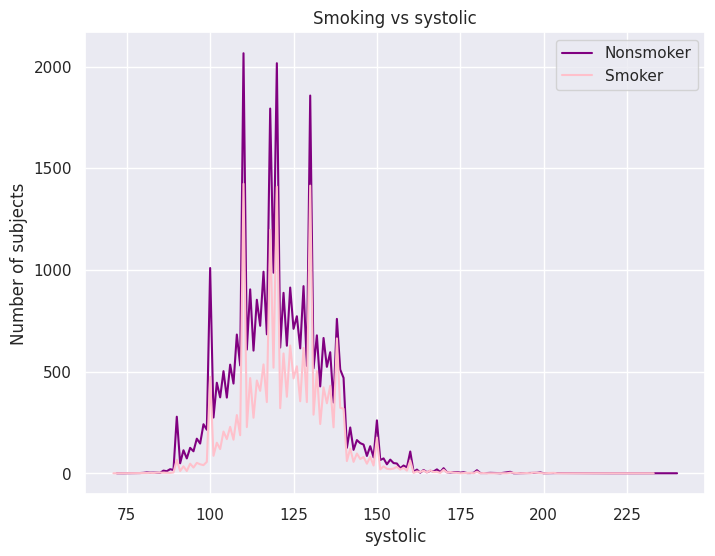

In [ ]:
eda('systolic') #not important

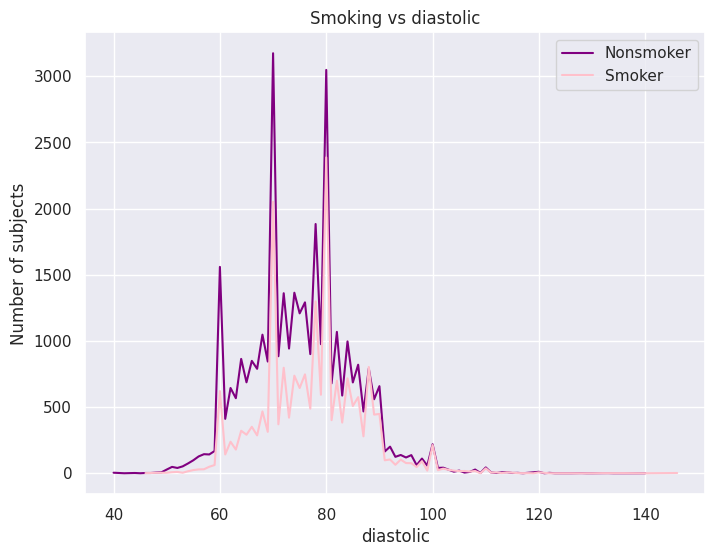

In [ ]:
eda('diastolic') #not important

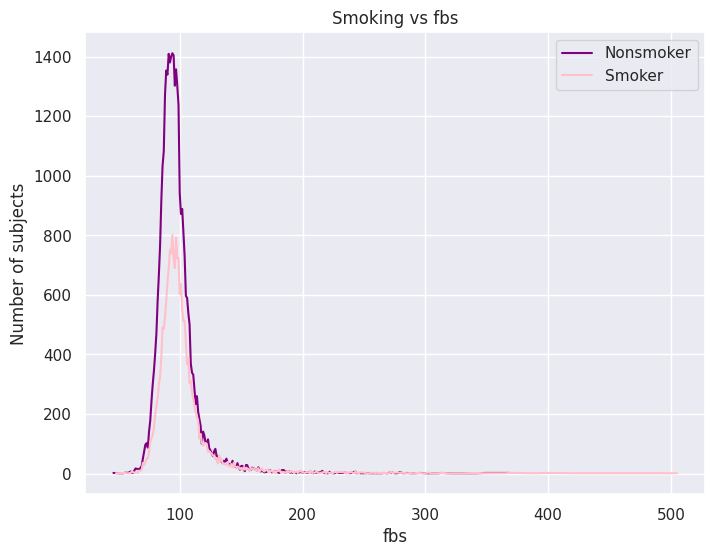

In [ ]:
eda('fbs') #not important

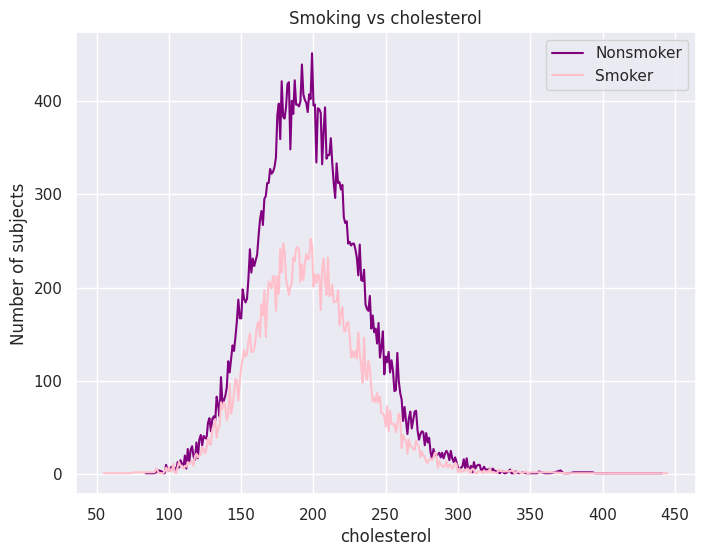

In [ ]:
eda('cholesterol') #not important

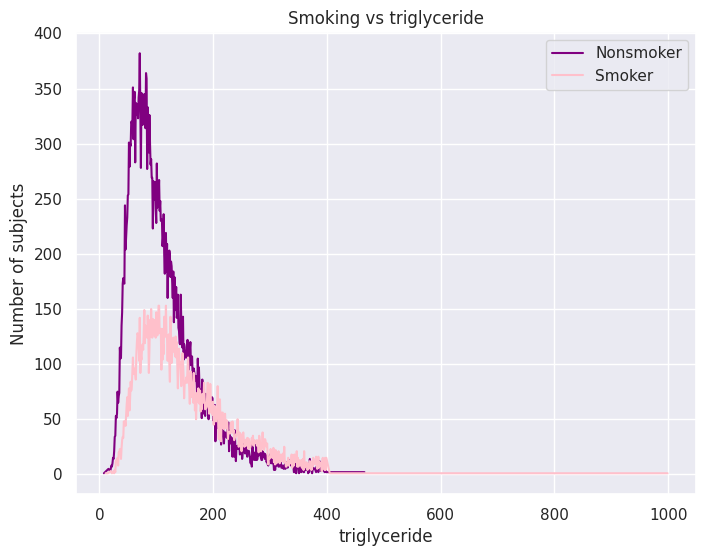

In [ ]:
eda('triglyceride') #probably not important

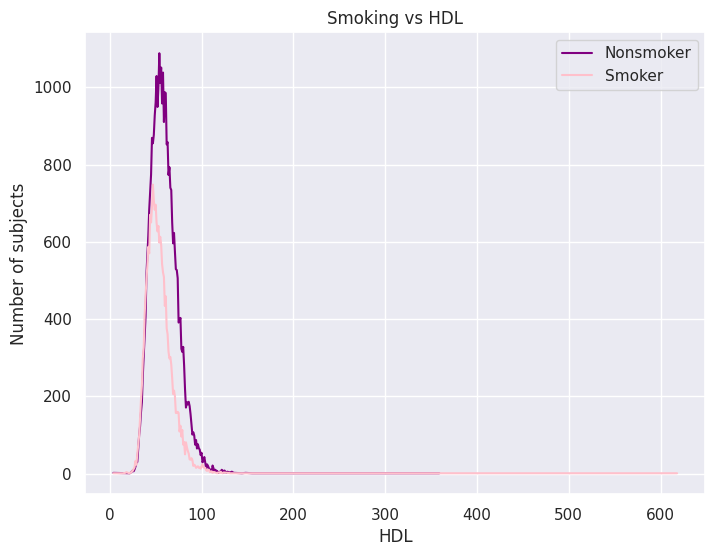

In [ ]:
eda('HDL') #might be important

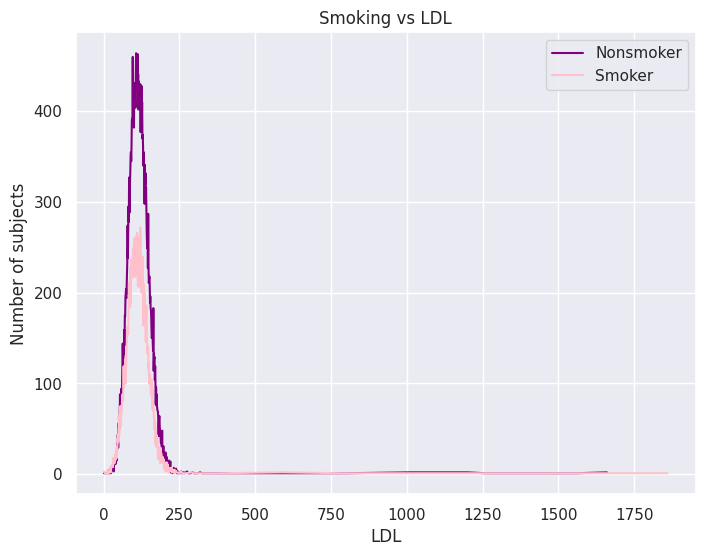

In [ ]:
eda('LDL') #not important

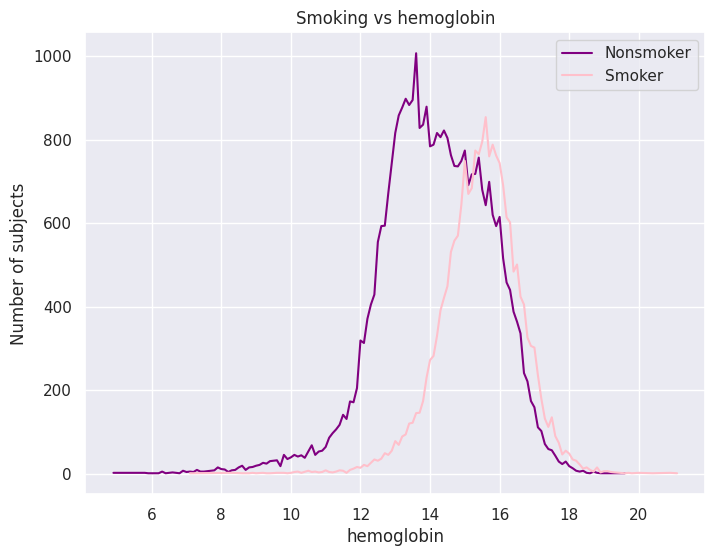

In [ ]:
eda('hemoglobin') #seems important

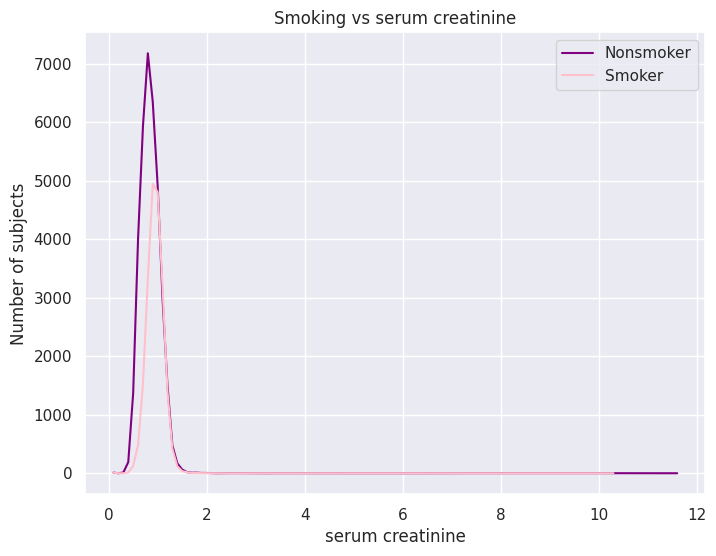

In [ ]:
eda('serum creatinine') #not important (?)

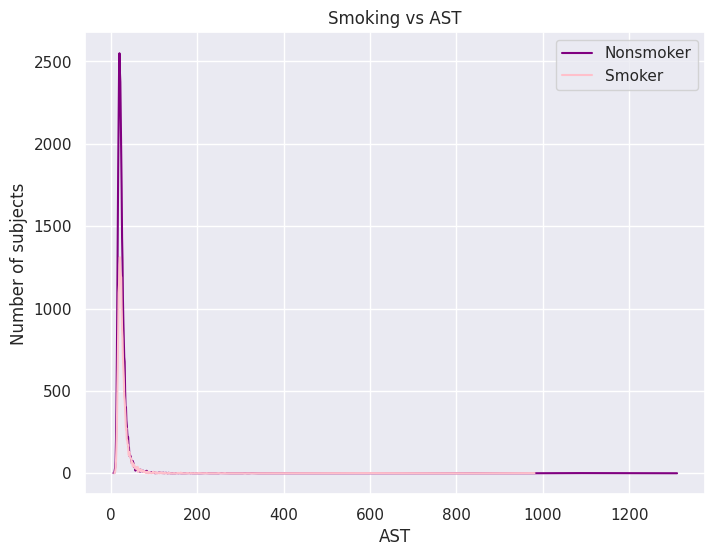

In [ ]:
eda('AST')


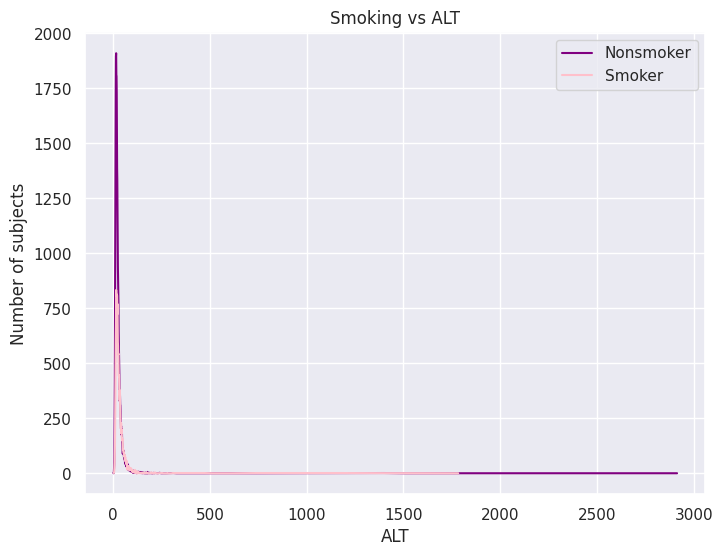

In [ ]:
eda('ALT') #not important

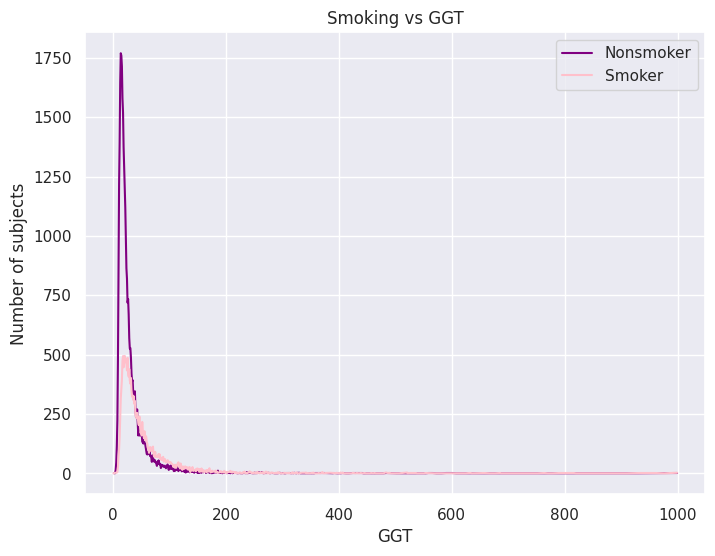

In [ ]:
eda('GGT') #probably not important

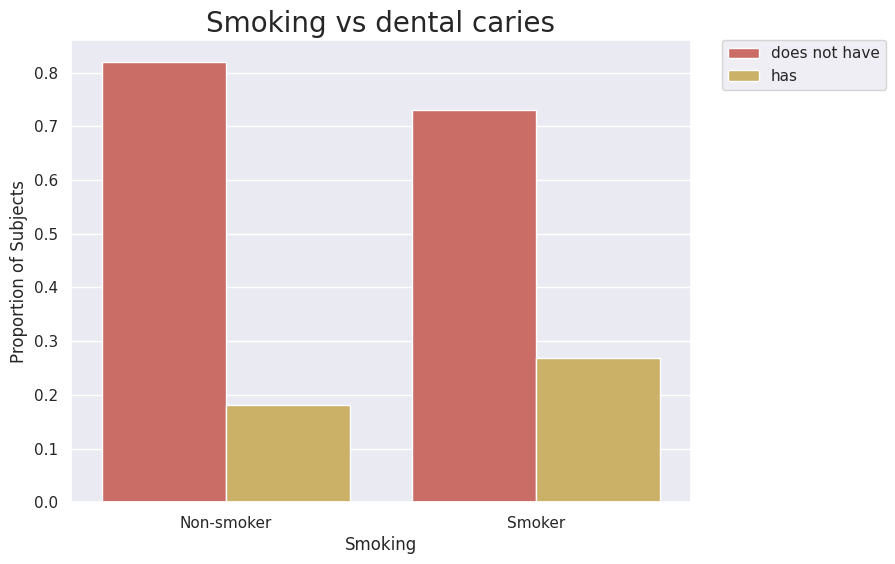

In [ ]:
eda1('dental caries', 'has', 'does not have') #might be important

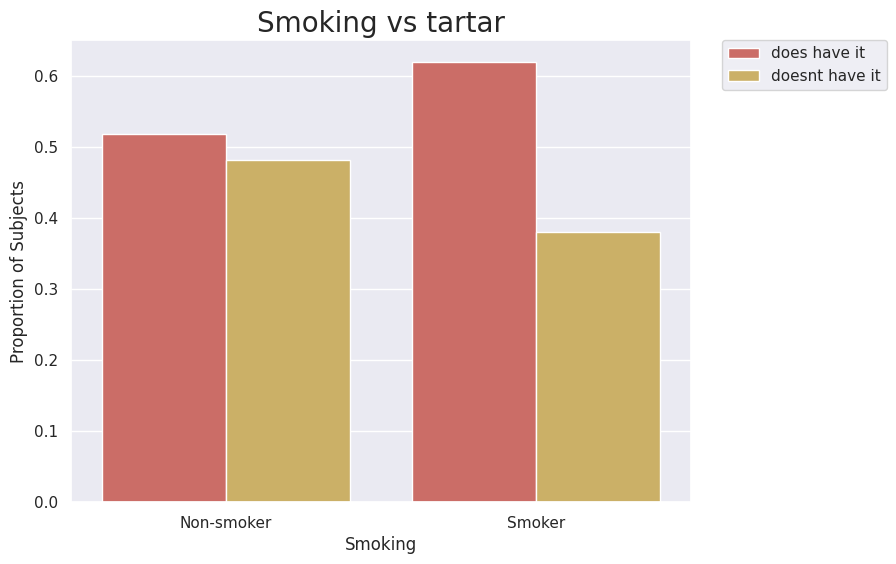

In [ ]:
eda1('tartar', 'doesnt have it', 'does have it ') #important


In [ ]:
y = data['smoking']
X = data[data.columns[1:-1]]
k_val = (3, 4, 5, 6, 7, 8, 9)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=7)
selector = SequentialFeatureSelector(estimator = knn, direction = 'forward', n_features_to_select='auto', scoring = 'accuracy', cv = 5)
selector.fit(X, y)
selected_feature_indices = selector.get_support(indices=True)

# Get the selected feature names
selected_features = X.columns[selected_feature_indices]
print(selected_features)

Index(['age', 'height', 'waist', 'triglyceride', 'HDL', 'hemoglobin',
       'serum creatinine', 'ALT', 'GGT', 'tartar'],
      dtype='object')


In [ ]:
X = data[['age', 'height', 'waist', 'triglyceride', 'HDL', 'hemoglobin',
       'serum creatinine', 'ALT', 'GGT', 'tartar']]


In [ ]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
k_val = (1, 2, 3, 4, 5, 6, 7, 8, 9)
kf = KFold(n_splits = 5, shuffle=True, random_state = 109)

train_scores = []
test_scores = []
results = pd.DataFrame(columns=['Fold', 'k_val', 'Train Accuracy', 'Test Accuracy'])

for k in k_val:
  knn = KNeighborsClassifier(n_neighbors = k)
  fold = 1


  for trlInd, testInd in kf.split(X):
   # testdf = data.iloc[testInd,]
    #traindf = data.iloc[trlInd,]
    #knn.fit(traindf, testdf)

    X_train, X_test = X.iloc[trlInd], X.iloc[testInd]
    y_train, y_test = y.iloc[trlInd], y.iloc[testInd]
    kn1 = knn.fit(X_train, y_train)


    accuracyTest = knn.score(X_test, y_test)
    accTrain = knn.score(X_train, y_train)
    test_scores.append(accuracyTest)
    train_scores.append(accTrain)

    results = results.append({
         'Fold': fold,
          'k_val': k,
          'Train Accuracy': accTrain,
          'Test Accuracy': accuracyTest
        }, ignore_index=True)

    fold += 1

results['Fold'] = results['Fold'].astype(int)







In [ ]:
results

,Fold,k_val,Train Accuracy,Test Accuracy
0,1,1.0,1.000000,0.773139
1,2,1.0,1.000000,0.779513
2,3,1.0,1.000000,0.772042
3,4,1.0,1.000000,0.769707
4,5,1.0,1.000000,0.777159
5,1,2.0,0.888380,0.722776
6,2,2.0,0.888986,0.728970
7,3,2.0,0.885195,0.721314
8,4,2.0,0.888091,0.728677
9,5,2.0,0.887956,0.737475


In [ ]:
max(test_scores)

0.7795134213125056

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 5)
x = data.drop('smoking' , axis = 1)
y = data['smoking']
kn1 = knn.fit(X, y)

In [ ]:

accuracy = kn1.score(X, y)
print(accuracy)

0.8187710981828629
